## **COMP8460 – Basic NLP Techniques Project**
### *Clinical Text Assistant: NLP-Powered Healthcare Text Analysis System*

In this notebook, we explore several *basic NLP techniques* using a dataset of healthcare drug reviews from [Kaggle](https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018?resource=download).  
The goal is to **clean, analyse, and understand** the text through methods like tokenisation, lemmatisation, and sentiment analysis.  
These approaches help reveal how patients describe their experiences with different medications.


## Import library and set reproducibility

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import re, html, random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Set reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Load data
train_df = pd.read_csv("drugsComTrain_raw.csv")
test_df  = pd.read_csv("drugsComTest_raw.csv")

# Merge into one dataset
df = pd.concat([train_df, test_df], ignore_index=True)
print("Combined shape:", df.shape)
df.head()


Combined shape: (215063, 7)


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


The dataset contains 215,063 reviews of various prescription drugs, with seven key attributes:  
`uniqueID`, `drugName`, `condition`, `review`, `rating`, `date`, and `usefulCount`.  

Each entry represents a patient’s review describing their experience with a medication, including its effectiveness and side effects.  
This dataset forms the basis for text preprocessing and analysis in the following sections.

## Text Preprocessing

### Data cleaning & normalisation

In [2]:
# Define normalisation function

def fast_clean(text: str) -> str:
    text = html.unescape(str(text)).lower()
    # remove links
    text = re.sub(r"https?://\S+|www\.\S+", " ", text)
    # keep letters/numbers and some medical units
    text = re.sub(r"[^a-z0-9\s.%/-]+", " ", text)
    # remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply to dataset and show comparison
df["clean_review"] = df["review"].apply(fast_clean)
df[["review", "clean_review"]].head()

,review,clean_review
0,"""It has no side effect, I take it in combinati...",it has no side effect i take it in combination...
1,"""My son is halfway through his fourth week of ...",my son is halfway through his fourth week of i...
2,"""I used to take another oral contraceptive, wh...",i used to take another oral contraceptive whic...
3,"""This is my first time using any form of birth...",this is my first time using any form of birth ...
4,"""Suboxone has completely turned my life around...",suboxone has completely turned my life around....


To prepare the data for analysis, all reviews were changed to lowercase and cleaned by removing URLs, punctuation, and extra spaces while keeping useful numeric or medical expressions (e.g., “5mg”, “20%”).    
This normalisation reduces noise and ensures consistent text formatting before tokenisation and lemmatisation.  
The table shows a comparison between the raw and cleaned text with the expected results.


### Tokenisation and lemmatisation

In [3]:
import spacy
# Disable heavy components to load quickly
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"])

# Apply to sample text
sample_text = df["clean_review"].iloc[0]
doc = nlp(sample_text)

# Tokenisation and lemmatisation
tokens = [t.text for t in doc]
lemmas = [t.lemma_ for t in doc if not t.is_stop and not t.is_punct]

# Display comparisons
print("ORIGINAL (cleaned):")
print(sample_text)
print("\nTOKENS:")
print(tokens[:25])
print("\nLEMMAS (no stopwords):")
print(lemmas[:25])


ORIGINAL (cleaned):
it has no side effect i take it in combination of bystolic 5 mg and fish oil

TOKENS:
['it', 'has', 'no', 'side', 'effect', 'i', 'take', 'it', 'in', 'combination', 'of', 'bystolic', '5', 'mg', 'and', 'fish', 'oil']

LEMMAS (no stopwords):
['effect', 'combination', 'bystolic', '5', 'mg', 'fish', 'oil']


We used `spaCy` to tokenise and lemmatise reviews so that forms (e.g. ‘taking’, ‘took’) map to a single form (‘take’).  
This reduces vocabulary size and improves text classification.

In [4]:
# Apply lemmatisation to first 5000 reviews
sample_idx = df.index[:5000]
lemmatised = []

for doc in nlp.pipe(df.loc[sample_idx, "clean_review"].tolist(), batch_size=1000):
    lemmas = [t.lemma_ for t in doc if not t.is_stop and not t.is_punct and not t.is_space]
    lemmatised.append(" ".join(lemmas))

df.loc[sample_idx, "clean_review"] = lemmatised


Since full lemmatisation of ~215k reviews is computationally expensive in Colab, we applied full spaCy lemmatisation to a representative subset (5,000 rows) and regex-based normalisation to the whole dataset.

### Visualisation

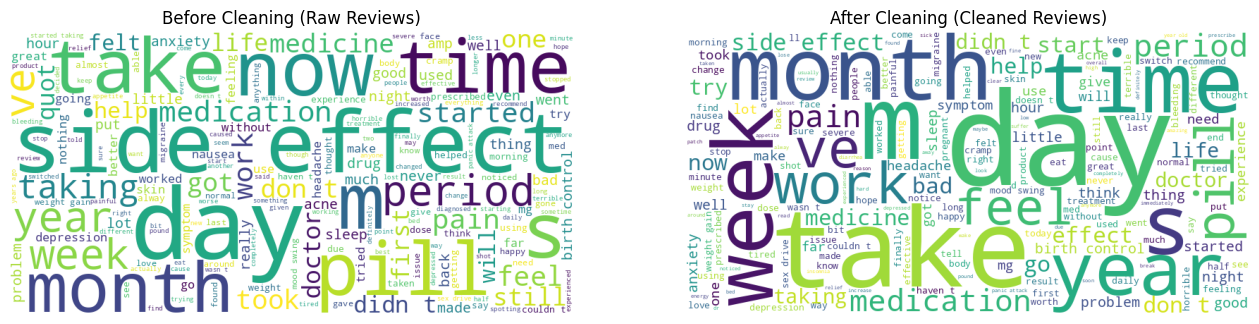

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Wordcloud before cleaning (raw reviews)
text_raw = " ".join(df["review"].dropna().astype(str).head(10000))
wc_raw = WordCloud(width=800, height=400, background_color="white").generate(text_raw)

# Wordcloud after cleaning (cleaned reviews)
text_clean = " ".join(df["clean_review"].dropna().astype(str).head(10000))
wc_clean = WordCloud(width=800, height=400, background_color="white").generate(text_clean)

# Plot comparison
plt.figure(figsize=(16,7))

plt.subplot(1,2,1)
plt.imshow(wc_raw)
plt.axis("off")
plt.title("Before Cleaning (Raw Reviews)")

plt.subplot(1,2,2)
plt.imshow(wc_clean)
plt.axis("off")
plt.title("After Cleaning (Cleaned Reviews)")

plt.show()

The figures generated shows the difference between raw and cleaned reviews.  
After preprocessing, the vocabulary becomes more focused on medical terms,   
confirming that cleaning and lemmatisation improved text quality.

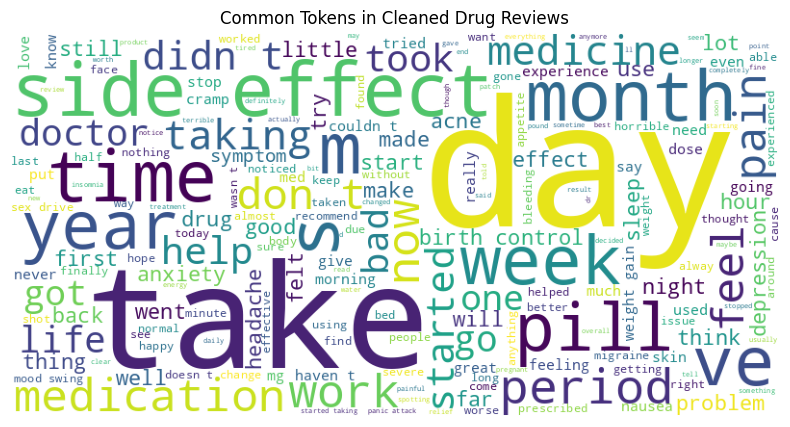

In [6]:
# Show token comparisons, clean vs. uncleaned
from wordcloud import WordCloud

text_blob = " ".join(df["clean_review"].dropna().head(20000).tolist())

wc = WordCloud(width=800, height=400, background_color="white").generate(text_blob)
plt.figure(figsize=(10,5))
plt.imshow(wc)
plt.axis("off")
plt.title("Common Tokens in Cleaned Drug Reviews")
plt.show()


The most frequent tokens, such as *“day”*, *“month”*, *“take”*, *“time”*, and *“week”*, implies how often patients describe their medication experiences in temporal terms.

Common medical and emotional words like *“pain”*, *“side effect”*, *“anxiety”*, and *“sleep”* show that user discussions focus on treatment effectiveness and symptom experiences.  

All text is lowercased and free of punctuation or noise, confirming that the text preprocessing effectively tokenised and lemmatised the dataset while keeping relevant healthcare context.


## Sentiment Analysis - TF-IDF + Logistic Regression


### Create labels

In [7]:
# Create label from Ratings for sentiment analysis
def make_label(r):
    try:
        r = float(r)
    except:
        return np.nan
    return 1 if r >= 7 else 0   # 1 = positive, 0 = negative

df["sentiment_label"] = df["rating"].apply(make_label)
df["sentiment_label"].value_counts(dropna=False)


,count
sentiment_label,
1,142306
0,72757


Drug ratings were converted into sentiment labels to support supervised learning.  

Reviews with ratings **7 and above** were labelled as **positive (1)**, while those below 7 were labelled as **negative (0)**.

This results in **142,306 positive** and **72,757 negative** samples, providing a balanced foundation for sentiment analysis.


### TF-IDF + Logistic Regression

In [8]:
# Remove rows without label or text
cls_df = df.dropna(subset=["clean_review", "sentiment_label"]).copy()
y = cls_df["sentiment_label"].astype(int)

tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=3,
    max_df=0.9,
    stop_words="english"
)

# Train with LogisticRegression
X = tfidf.fit_transform(cls_df["clean_review"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Fit and transform
clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)

# Display score
print(f"""
Sentiment model:
Accuracy: {acc:.3f}
F1: {f1:.3f}
""")


Sentiment model:
Accuracy: 0.860
F1: 0.898



A sentiment classification model was trained using TF-IDF vectorisation followed by Logistic Regression.  
The model achieved an **accuracy of 0.86** and an **F1-score of 0.90**,   
showing that the features successfully capture positive and negative tones in drug reviews.  
This provides a strong baseline for evaluating the advanced models.


### Visualisation

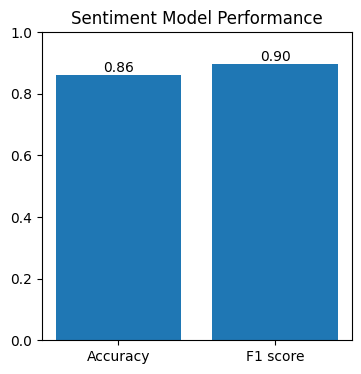

In [9]:
# Create bar chart
metrics = ["Accuracy", "F1 score"]
values = [acc, f1]

plt.figure(figsize=(4,4))
plt.bar(metrics, values)
plt.ylim(0, 1)
plt.title("Sentiment Model Performance")
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center")
plt.show()


The chart compares the model’s **Accuracy (0.86)** and **F1-score (0.90)**,   showing that it performs consistently across both metrics.  
A high F1-score shows strong balance between precision and recall,   
meaning the classifier correctly identifies both positive and negative reviews.  
This confirms that the TF-IDF + Logistic Regression model is reliable for sentiment prediction.


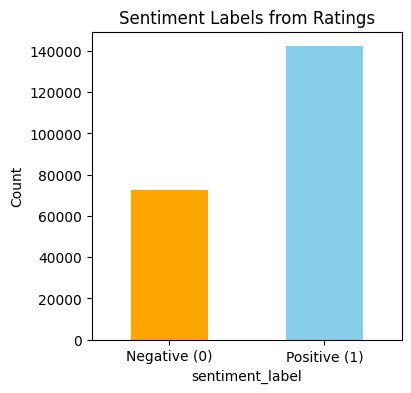

In [10]:
# Compare positive vs. negative rating
sent_counts = df["sentiment_label"].value_counts().sort_index()

plt.figure(figsize=(4,4))
colors = ["orange", "skyblue"]
sent_counts.plot(kind="bar", color=colors)
plt.xticks([0,1], ["Negative (0)", "Positive (1)"], rotation=0)
plt.title("Sentiment Labels from Ratings")
plt.ylabel("Count")
plt.show()

In [11]:
# Pick 5 random examples from the dataset
sample_df = cls_df.sample(5, random_state=42)[["clean_review", "sentiment_label"]]

# Transform with TF-IDF vectorizer
X_sample = tfidf.transform(sample_df["clean_review"])

# Predict with trained classifier
preds = clf.predict(X_sample)

# Display each sentence with actual + predicted sentiment
for i, row in enumerate(sample_df.itertuples()):
    actual = "Positive 😀" if row.sentiment_label == 1 else "Negative 😞"
    predicted = "Positive 😀" if preds[i] == 1 else "Negative 😞"
    print(f"\nReview:\n{row.clean_review}\n→ Actual: {actual}, Predicted: {predicted}")



Review:
i suffered a .45 caliber gsw to the head in 2009. have had multiple omfs/ent surgeries. i have developed a chronic pain condition as a result of the accident. this medication has been a lifesaver. it allows me to function at work and has restored my quality of life. for me it works significantly better than percocet.
→ Actual: Positive 😀, Predicted: Positive 😀

Review:
i started on viibryd after having a dna test done where i found out other medications aren t effective for me due to the way my brain processes them. the first week was fine with no symptoms and no noticeable changes. when i went up to 20mg i had terrible crying spells couldn t sleep at night had muscle aches insane migraines was exhausted irritable and my anxiety worsened. i lowered myself back down to 10mg and the symptoms lessened. my doctor told me to take the medication with dinner and a full meal. after reading other reviews the symptoms may have been so bad since i wasn t taking the medication at the exac

The sentence *“not covered by insurance”* was misclassified as positive.  
Although it is clearly a negative experience in context, the model failed to detect negativity
because the review lacks explicit sentiment words and was likely outside the main training distribution
(focused on drug effectiveness and side effects).  
This shows a limitation of TF-IDF-based models and motivates the use of contextual
embeddings or LLMs in the advanced stage of our project.

# Rule-based Information Extraction (Regex)

In [18]:
import re

# Combine dosage pattern (e.g. 5mg, 10 ml, 0.5 g)
dose_pat = re.compile(r"\b(\d+(?:\.\d+)?)\s*[-]?\s*(mg|ml|mcg|g|µg)s?\b", re.I)

# Apply regex
def extract_dosage(text):
    text = str(text)
    matches = dose_pat.findall(text)            # -> list of (number, unit)
    if matches:
        return ", ".join(f"{num}{unit.lower()}" for num, unit in matches)
    else:
        return "no dosage detected"

# Apply to dataset
df["dosage"] = df["review"].astype(str).apply(extract_dosage)
df[["review","dosage"]].head(10)


,review,dosage
0,"""It has no side effect, I take it in combinati...",5mg
1,"""My son is halfway through his fourth week of ...",no dosage detected
2,"""I used to take another oral contraceptive, wh...",no dosage detected
3,"""This is my first time using any form of birth...",no dosage detected
4,"""Suboxone has completely turned my life around...",no dosage detected
5,"""2nd day on 5mg started to work with rock hard...",5mg
6,"""He pulled out, but he cummed a bit in me. I t...",no dosage detected
7,"""Abilify changed my life. There is hope. I was...","2mg, 5mg"
8,""" I Ve had nothing but problems with the Kepp...",no dosage detected
9,"""I had been on the pill for many years. When m...",no dosage detected


To identify medical dosage information (e.g. *“5mg”*, *“10 ml”*) within user reviews,
we implemented a **regular expression (regex)** pattern that searches for numeric values
followed by common dosage units (mg, ml, mcg, g).  
This method enables quick extraction of dosage mentions without requiring model-based NER.

For cases where no dosage pattern is detected, the function returns
**"no dosage detected"** to maintain consistent outputs.

# Named Entity Recognition (NER) + Part-of-Speech (POS)

In [13]:
import spacy

nlp_full = spacy.load("en_core_web_sm")

sample_size = 200
sample_texts = df["clean_review"].head(sample_size).tolist()

ner_results = []
pos_results = []

for doc in nlp_full.pipe(sample_texts, batch_size=50):
    ents = [(ent.text, ent.label_) for ent in doc.ents]
    ner_results.append(ents)

    pos_tags = [(token.text, token.pos_) for token in doc]
    pos_results.append(pos_tags)

# Assign to dataset
df.loc[df.index[:sample_size], "ner_entities"] = pd.Series(ner_results).values
df.loc[df.index[:sample_size], "pos_tags"] = pd.Series(pos_results).values

df[["clean_review", "ner_entities", "pos_tags"]].head(10)


,clean_review,ner_entities,pos_tags
0,effect combination bystolic 5 mg fish oil,"[(5, CARDINAL)]","[(effect, NOUN), (combination, NOUN), (bystoli..."
1,son halfway fourth week intuniv concerned begi...,"[(fourth week, DATE), (week, DATE), (nearly 8 ...","[(son, PROPN), (halfway, PROPN), (fourth, ADJ)..."
2,oral contraceptive 21 pill cycle happy- light ...,"[(21, CARDINAL), (5 day, DATE), (last week, DA...","[(oral, ADJ), (contraceptive, ADJ), (21, NUM),..."
3,time form birth control m glad go patch 8 mont...,"[(8 month, DATE), (3 4 day, DATE), (max, PERSON)]","[(time, NOUN), (form, VERB), (birth, NOUN), (c..."
4,suboxone completely turn life feel healthy m e...,"[(year, DATE)]","[(suboxone, NOUN), (completely, ADV), (turn, V..."
5,2nd day 5 mg start work rock hard erection exp...,"[(2nd day 5, DATE), (3rd day, DATE), (leg ankl...","[(2nd, ADJ), (day, NOUN), (5, NUM), (mg, NOUN)..."
6,pull cumme bit take plan b 26 hour later take ...,"[(26 hour, TIME), (week later, DATE)]","[(pull, VERB), (cumme, NOUN), (bit, NOUN), (ta..."
7,abilify change life hope zoloft clonidine star...,"[(age 15, DATE), (second, ORDINAL), (2, CARDIN...","[(abilify, NOUN), (change, VERB), (life, PROPN..."
8,ve problem keppera constant shake arm leg pin ...,[],"[(ve, AUX), (problem, NOUN), (keppera, NOUN), ..."
9,pill year doctor change rx chateal effective h...,"[(6 month, DATE), (age 28, DATE), (today, DATE...","[(pill, NOUN), (year, NOUN), (doctor, NOUN), (..."


 spaCy detected entities such as quantities and dates (e.g., “5mg”, “fourth week”), which represent dosage and treatment duration in reviews.

POS tagging identified frequent nouns (pain, effect), verbs (take, feel), and adjectives (great, terrible), showing how users describe symptoms and experiences.  

This demonstrates that linguistic patterns can reveal key medical and emotional themes within patient reviews.


# Text Clustering (TF-IDF + KMeans)

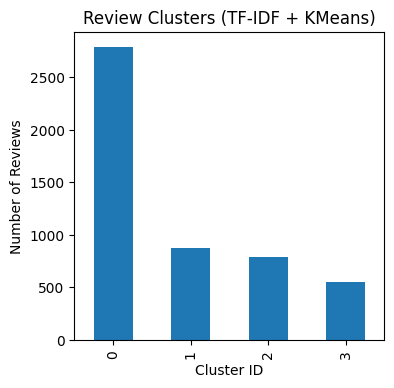

In [14]:
# Apply clustering on a subset
cluster_df = cls_df.head(5000).copy()
X_cluster = tfidf.transform(cluster_df["clean_review"])

kmeans = KMeans(n_clusters=4, random_state=SEED, n_init=10)
kmeans.fit(X_cluster)

cluster_df["cluster"] = kmeans.labels_

# Show clusters back
df.loc[cluster_df.index, "cluster"] = cluster_df["cluster"]

# Visualise cluster sizes
cluster_counts = cluster_df["cluster"].value_counts().sort_index()

plt.figure(figsize=(4,4))
cluster_counts.plot(kind="bar")
plt.title("Review Clusters (TF-IDF + KMeans)")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Reviews")
plt.show()



We applied K-Means clustering (k=4) on TF-IDF vectors to group similar drug reviews by textual patterns.  

Cluster 0 dominates the dataset, suggesting one large group of reviews shares common vocabulary (possibly general feedback), while smaller clusters may represent specific topics like side effects or dosage experiences.

This clustering helps identify hidden themes in patient reviews without labelled data.


### Interpreting the clusters

In [15]:
import numpy as np

# Find feature names from TF-IDF vectorizer
terms = tfidf.get_feature_names_out()

# Number of top words to display per cluster
n_terms = 10

for i in range(kmeans.n_clusters):
    top_terms = [terms[ind] for ind in np.argsort(kmeans.cluster_centers_[i])[-n_terms:]]
    print(f"Cluster {i} Top Terms: {', '.join(top_terms)}")


Cluster 0 Top Terms: try, month, week, help, pain, feel, year, start, day, effect
Cluster 1 Top Terms: swing, year, mood swing, control, birth control, birth, cramp, pill, month, period
Cluster 2 Top Terms: help, week, work, effect, anxiety, year, start, feel, day, mg
Cluster 3 Top Terms: pain, medicine, year, hour, day, start, effect, great, work great, work


Based on the results, it can be inferred that:  
- Cluster 0 shows general experiences (e.g., *help*, *pain*, *effect*).  
- Cluster 1 focuses on reproductive health and menstrual cycles (*birth control*, *cramp*, *period*).  
- Cluster 2 overlaps positive responses and mild side effects (*work*, *anxiety*, *feel*).  
- Cluster 3 highlights treatment and medication effectiveness (*medicine*, *work great*).  

These clusters capture different angles of patient feedback, from emotional tone to treatment context.

# Save final cleaned data for Advanced Techniques

In [19]:
cols_to_keep = [
    "drugName",
    "condition",
    "clean_review",
    "rating",
    "sentiment_label",
    "dosage",
    "ner_entities",
    "pos_tags",
    "cluster"
]

drugs_cleaned = df[cols_to_keep].copy()
drugs_cleaned.to_csv("drugs_cleaned.csv", index=False)
print("✅ saved drugs_cleaned.csv with shape:", drugs_cleaned.shape)

✅ saved drugs_cleaned.csv with shape: (215063, 9)


We selected important columns — including metadata (drug name, condition, rating), text features (cleaned reviews, NER, POS), and created variables (sentiment label, dosage, clusters).  

These are combined into one dataframe and saved as **`drugs_cleaned.csv`** for use in the advanced techniques.  

This ensures all preprocessing outputs are reproducible and ready for further modelling and analysis.